# Part 2
# Term Deposit Marketing - ML Project
---


**Part 2 Objective:**

In this second part of the project, we focus on identifying clients who are likely to subscribe to the Term Deposit. The goal is to help the bank understand the key segments within this group, enabling more targeted and effective marketing campaigns based on client profiles.

**Data Description:**

- **age**: Age of the customer
- **job**: Type of job (e.g., admin, technician, blue-collar)
- **marital**: Marital status (e.g., married, single)
- **education**: Level of education
- **default**: Has credit in default (yes/no)
- **balance**: Average yearly account balance in euros
- **housing**: Has a housing loan (yes/no)
- **loan**: Has a personal loan (yes/no)
- **contact**: Contact communication type (e.g., cellular, telephone)
- **day**: Last contact day of the month
- **month**: Last contact month (e.g., may, jul)
- **duration**: Duration of the last contact in seconds
- **campaign**: Number of contact attempts made during the campaign
- **Target (y)**: Indicates if the customer subscribed to a term deposit (yes/no)


**Plan of work:**

Segment the subscriber population (y=1) using unsupervised learning (clustering), to identify meaningful client profiles the bank should focus on.

The clustering will be used as a profiling tool, not a prediction tool. The goal is actionable segmentation, meaning the business can say: “Let’s prioritize Cluster 2: students and retirees contacted in July with high balances”.

For the part 2 I will use `DuckDB` which is an excellent choice when working with tabular data and want fast, in-memory analytics using SQL. Perfect for exploring or preprocessing datasets like ours.

----

### 1. Load the Dataset into DuckDB

In [2]:
import duckdb
import pandas as pd

In [3]:
# Load directly into DuckDB from CSV
con = duckdb.connect()
con.execute("""
    CREATE OR REPLACE TABLE term_deposit AS
    SELECT * FROM read_csv_auto('term-deposit-marketing.csv', header=True)
""")

In [ ]:
# Check the first few rows
df_preview = con.execute("SELECT * FROM term_deposit LIMIT 5").df()
print(df_preview)

   age           job  marital  education  default  balance  housing   loan  \
0   58    management  married   tertiary    False     2143     True  False   
1   44    technician   single  secondary    False       29     True  False   
2   33  entrepreneur  married  secondary    False        2     True   True   
3   47   blue-collar  married    unknown    False     1506     True  False   
4   33       unknown   single    unknown    False        1    False  False   

   contact  day month  duration  campaign      y  
0  unknown    5   may       261         1  False  
1  unknown    5   may       151         1  False  
2  unknown    5   may        76         1  False  
3  unknown    5   may        92         1  False  
4  unknown    5   may       198         1  False  


In [7]:
# Duckdb native visualization (no need of pandas)
con.execute("SELECT * FROM term_deposit LIMIT 5").fetchdf()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,False,2143,True,False,unknown,5,may,261,1,False
1,44,technician,single,secondary,False,29,True,False,unknown,5,may,151,1,False
2,33,entrepreneur,married,secondary,False,2,True,True,unknown,5,may,76,1,False
3,47,blue-collar,married,unknown,False,1506,True,False,unknown,5,may,92,1,False
4,33,unknown,single,unknown,False,1,False,False,unknown,5,may,198,1,False


In [8]:
con.execute("PRAGMA table_info('term_deposit')").fetchdf()

,cid,name,type,notnull,dflt_value,pk
0,0,age,BIGINT,False,None,False
1,1,job,VARCHAR,False,None,False
2,2,marital,VARCHAR,False,None,False
3,3,education,VARCHAR,False,None,False
4,4,default,BOOLEAN,False,None,False
5,5,balance,BIGINT,False,None,False
6,6,housing,BOOLEAN,False,None,False
7,7,loan,BOOLEAN,False,None,False
8,8,contact,VARCHAR,False,None,False
9,9,day,BIGINT,False,None,False


In [10]:
con.execute("""
    SELECT 
        COUNT(*) AS count,
        AVG(age) AS mean_age,
        STDDEV(age) AS std_age,
        MIN(age) AS min_age,
        MAX(age) AS max_age,

        AVG(balance) AS mean_balance,
        STDDEV(balance) AS std_balance,
        MIN(balance) AS min_balance,
        MAX(balance) AS max_balance,

        AVG(duration) AS mean_duration,
        STDDEV(duration) AS std_duration,
        MIN(duration) AS min_duration,
        MAX(duration) AS max_duration

    FROM term_deposit;
""").fetchdf()

,count,mean_age,std_age,min_age,max_age,mean_balance,std_balance,min_balance,max_balance,mean_duration,std_duration,min_duration,max_duration
0,40000,40.5446,9.641776,19,95,1274.27755,2903.769716,-8019,102127,254.8243,259.366498,0,4918


### 2. Explore & Clean the Data

In [12]:
con.execute("""
    SELECT
    COUNT(*) AS total_rows,
    COUNT(age) AS non_null_age,
    COUNT(job) AS non_null_job,
    COUNT(balance) AS non_null_balance,
    COUNT(duration) AS non_null_duration
    FROM term_deposit;
""").fetchdf()

,total_rows,non_null_age,non_null_job,non_null_balance,non_null_duration
0,40000,40000,40000,40000,40000


#### 2.1 Select Features for Clustering

Because there are columns related with the call campaign that can add noise to the client's clustering process, we decide clean some columns:

In [19]:
con.execute("""
    CREATE OR REPLACE VIEW term_deposit_clean AS
    SELECT
        age,
        job,
        marital,
        education,
        "default" AS has_default,
        balance,
        housing AS has_housing,
        loan AS has_loan,
        y AS target
    FROM term_deposit
""")


#### 2.2 Understand Categorical Columns

In [16]:
categoricals = ['job', 'marital', 'education']
for col in categoricals:
    print(f"\nValue counts for '{col}':")
    print(con.execute(f"""
        SELECT {col}, COUNT(*) AS count 
        FROM term_deposit 
        GROUP BY {col} 
        ORDER BY count DESC
    """).fetchdf())




Value counts for 'job':
              job  count
0     blue-collar   9383
1      management   8166
2      technician   6852
3           admin   4483
4        services   3910
5         retired   1437
6   self-employed   1414
7    entrepreneur   1405
8      unemployed   1104
9       housemaid   1087
10        student    524
11        unknown    235

Value counts for 'marital':
    marital  count
0   married  24386
1    single  10889
2  divorced   4725

Value counts for 'education':
   education  count
0  secondary  20993
1   tertiary  11206
2    primary   6270
3    unknown   1531


#### 3. Encoding and Feature Engineering (SQL)

DuckDB does not support Z_SCORE() as a built-in SQL function. Then, we will perform the calculation in 2-steps.

In [26]:
mean_age, std_age, mean_balance, std_balance = con.execute("""
    SELECT
       AVG(age) AS mean_age,
       STDDEV_SAMP(age) AS std_age,
       AVG(LOG(ABS(balance) + 1)) AS mean_balance,
       STDDEV_SAMP(LOG(ABS(balance) + 1)) AS std_balance
    FROM term_deposit_clean
""").fetchone()


In [30]:
con.execute(f"""
CREATE OR REPLACE VIEW term_deposit_encoded AS
SELECT
    -- Standardize age manually
    (age - {mean_age}) / {std_age} AS age_t,

    -- Log-transform + standardize balance
    SIGN(balance) AS balance_sign,
    (LOG(ABS(balance) + 1) - {mean_balance}) / {std_balance} AS balance_t,

    -- One-hot encode job
    (job = 'admin.')::INT AS job_admin,
    (job = 'blue-collar')::INT AS job_bluecollar,
    (job = 'technician')::INT AS job_technician,
    (job = 'services')::INT AS job_services,
    (job = 'management')::INT AS job_management,
    (job = 'retired')::INT AS job_retired,
    (job = 'self-employed')::INT AS job_selfemployed,
    (job = 'entrepreneur')::INT AS job_entrepreneur,
    (job = 'unemployed')::INT AS job_unemployed,
    (job = 'housemaid')::INT AS job_housemaid,
    (job = 'student')::INT AS job_student,
    (job = 'unknown')::INT AS job_unknown,

    -- One-hot encode marital
    (marital = 'married')::INT AS marital_married,
    (marital = 'single')::INT AS marital_single,
    (marital = 'divorced')::INT AS marital_divorced,
    (marital = 'unknown')::INT AS marital_unknown,

    -- Ordinal encode education
    CASE 
        WHEN education = 'unknown' THEN -1
        WHEN education = 'primary' THEN 0
        WHEN education = 'secondary' THEN 1
        WHEN education = 'tertiary' THEN 2
    END AS education_ord,

    -- Binary encode default, housing, loan
    (has_default = 'yes')::INT AS default_bin,
    (has_housing = 'yes')::INT AS housing_bin,
    (has_loan = 'yes')::INT AS loan_bin,

    -- Binary encode target
    (target = 'yes')::INT AS target_bin

FROM term_deposit_clean
""")

In [31]:
con.execute("SELECT * FROM term_deposit_encoded LIMIT 10").fetchdf()


,age_t,balance_sign,balance_t,job_admin,job_bluecollar,job_technician,job_services,job_management,job_retired,job_selfemployed,...,job_unknown,marital_married,marital_single,marital_divorced,marital_unknown,education_ord,default_bin,housing_bin,loan_bin,target_bin
0,1.810393,1,0.862542,0,0,0,0,1,0,0,...,0,1,0,0,0,2,0,1,0,0
1,0.358378,1,-0.975680,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,-0.782491,1,-1.967114,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
3,0.669524,1,0.710742,0,1,0,0,0,0,0,...,0,1,0,0,0,-1,0,1,0,0
4,-0.782491,1,-2.141697,0,0,0,0,0,0,0,...,1,0,1,0,0,-1,0,0,0,0
5,-0.575060,1,-0.094922,0,0,0,0,1,0,0,...,0,1,0,0,0,2,0,1,0,0
6,-1.301067,1,0.188420,0,0,0,0,1,0,0,...,0,0,1,0,0,2,0,1,1,0
7,0.150947,1,-1.967114,0,0,0,0,0,0,0,...,0,0,0,1,0,2,1,1,0,0
8,1.810393,1,-0.371660,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
9,0.254663,1,0.309879,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


Double checking the target imbalance: 

In [37]:
con.execute("""
    SELECT 
        target_bin,
        count(*) AS count
    FROM term_deposit_encoded
    GROUP BY target_bin
""").fetchdf()

,target_bin,count
0,0,37104
1,1,2896


#### 4. Subscriber Segmentation Preparation

In this section, we focus exclusively on clients who subscribed to the term deposit (y == 1). Our objective is to apply clustering techniques to this subset in order to uncover natural segments among the subscribers and better understand their profiles.

To do this, we:
- Filter the dataset to include only subscribers.
- Select relevant engineered and encoded features for clustering (e.g., standardized age, log-transformed balance, job and marital status, etc.).
- Create a dedicated SQL view (subscribers_for_clustering) that will serve as the input for the K-Means algorithm.

This segmentation will help us identify distinct subscriber groups and support more targeted marketing strategies.



In [39]:
con.execute("""
    CREATE OR REPLACE VIEW subscribers_for_clustering AS
    SELECT
        age_t,
        balance_sign,
        balance_t,
        job_admin,
        job_bluecollar,
        job_technician,
        job_services,
        job_management,
        job_retired,
        job_selfemployed,
        job_entrepreneur,
        job_unemployed,
        job_housemaid,
        job_student,
        job_unknown,
        marital_married,
        marital_single,
        marital_divorced,
        marital_unknown,
        education_ord,
        default_bin,
        housing_bin,
        loan_bin
    FROM term_deposit_encoded
    WHERE target_bin = 1;
""")

In this step, we created a SQL **view** (subscribers_for_clustering) instead of a physical table to keep our data pipeline lightweight, modular, and fully in-memory. Since DuckDB operates in-process and often in-memory, using a view allows us to filter and transform the data on-the-fly without duplicating it or storing unnecessary intermediate results. This makes the workflow more efficient and easier to maintain, especially during exploratory analysis.


#### 4.1 Visualizing the data before Segmentation - 2D

In [40]:
# Export data BEFORE clustering
df_before = con.execute("SELECT * FROM subscribers_for_clustering").fetchdf()


In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [42]:
# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
before_pca = pca.fit_transform(df_before)

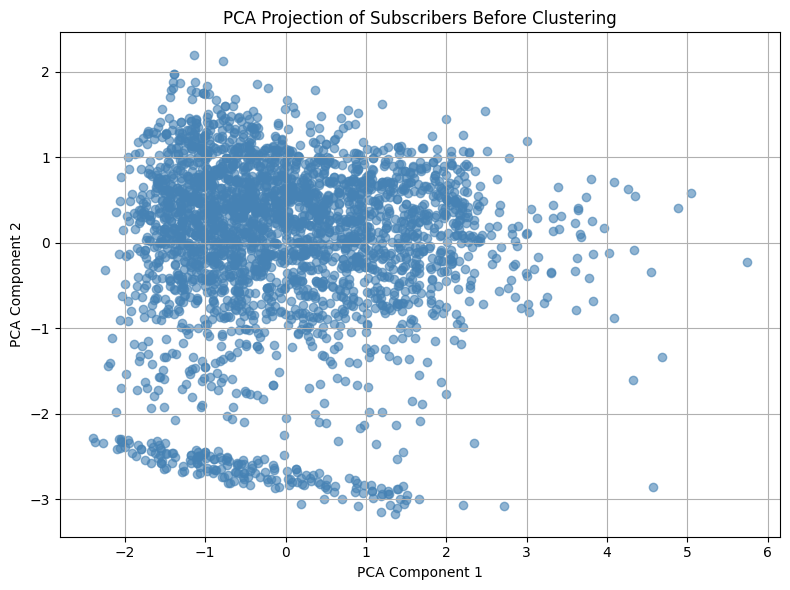

In [43]:
# Plot the 2D projection
plt.figure(figsize=(8, 6))
plt.scatter(before_pca[:, 0], before_pca[:, 1], alpha=0.6, color='steelblue')
plt.title("PCA Projection of Subscribers Before Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
print("Explained variance ratio (2 components):", pca.explained_variance_ratio_)
print("Total variance captured:", pca.explained_variance_ratio_.sum())


Explained variance ratio (2 components): [0.30595014 0.20194168]
Total variance captured: 0.5078918204064511


#### 4.1 Visualizing the data before Segmentation - 3D

By adding a third principal component, we can:
- Capture more variance. Get closer to the true structure of the original data.
- Visualize more separation. 3D plots can reveal clusters that are overlapping in 2D.
- Confirm if the third component adds meaningful structure or just noise.



In [46]:
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [47]:
X = df_before.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA with 3 components
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)


In [48]:
# Explained variance
explained_var = pca_3d.explained_variance_ratio_
print(f"Explained variance ratio (3 components): {explained_var}")
print(f"Total variance captured: {explained_var.sum()}")


Explained variance ratio (3 components): [0.11430175 0.0911153  0.07501541]
Total variance captured: 0.2804324579370616


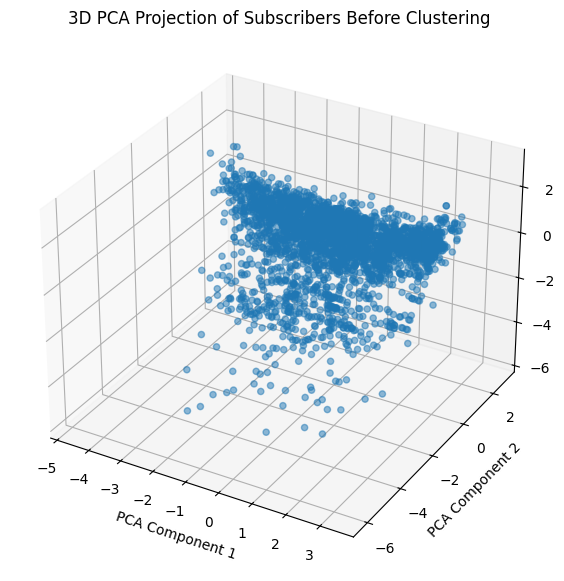

In [49]:
# 3D Scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], s=20, alpha=0.5)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA Projection of Subscribers Before Clustering')
plt.show()


##### Conclusion about the visualization:
The 2D PCA projection is significantly more informative in terms of variance captured.
With just two components, it retained over 50% of the variance.
Meanwhile, the 3D PCA projection only retained about 28%, meaning each component added relatively little.

**This can happens because:**
- PCA orders components by variance explained. So, the first few components usually capture the most signal.
- After that, additional components may capture noise or very small variations. Which don’t help clustering much and may just add complexity.

#### 4.2 Run K-Means for multiple values of K

We’ll compute the inertia (within-cluster sum of squares) for different values of k and plot the results.

In [53]:
from sklearn.cluster import KMeans
from random import randint


In [55]:
#seed = randint(10000,99999)
#seed
seed = 23

In [57]:
# Use only the features
X = df_before.copy()

# Range of k values to try
k_values = range(2, 11)
inertias = []

# Run KMeans for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)


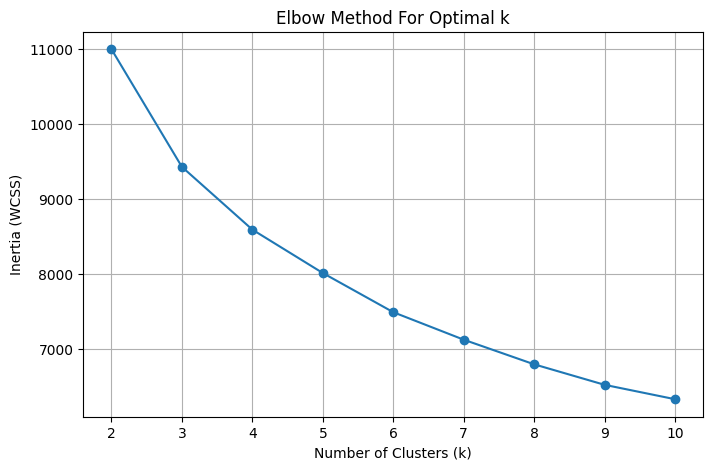

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()


**Elbow Analysis**

From the chart, we can observe:
- A steep drop in inertia from k=2 to k=3
- A noticeable bend (the "elbow") at k=4 or k=5
- After k=5, the improvements in inertia begin to diminish more gradually.

#### Choosing k for Clustering

The Elbow Method plot suggests a clear drop in inertia between k=2 and k=4, with a noticeable "elbow" around k=4 and a smaller bend at k=5. While k=4 offers a simpler and more interpretable segmentation, k=5 could reveal finer-grained subgroups within our subscriber base. To balance interpretability with potential insight, we proceed with both values (k=4 and k=5) to compare cluster structure, visualize distributions, and evaluate which segmentation better supports business decision-making.

#### 4.1 Run K-Means clustering with DuckDB

DuckDB has a built-in K-Means function that lets us cluster directly in SQL.